In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from prometheus_pandas import query
from IPython.display import Markdown, display
import urllib.parse
from scipy.signal import argrelmax

p = query.Prometheus('http://192.168.178.67:9090')
DEFAULT_STEP="1s"

DEBUG=False

# We're scraping much more data than we actually need.
# This is especially true for devices.
# In this section we define which devices we actually want to analyze.
NET_DEVICES=["docker0","enp7s0","lo"]
DISK_DEVICES=["sda"]
# The default range for sliding window aggregations
DEFAULT_RANGE="10s"

# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"
interrupts_filter = "{devices=\"\"}"

# Styling
sns.set_theme(style="ticks",palette="tab10")
sns.set_style("ticks",{'axes.grid' : True})

# Utils

In [37]:
def remove_meta_columns(df):
    cols = [col for col in df.columns if col not in ['measurement', 'delta', 'seconds']]
    return df[cols]

    
def describe_measurement_dataframe(df):
    display(Markdown("### Total "))
    display(remove_meta_columns(df).describe())
    
    #display(Markdown("### Per Measurement"))
    #display(df[df.columns.difference(['seconds'])].groupby('measurement').describe().unstack(1))

def fetch_query_range(query, start, end, step=DEFAULT_STEP, offset_start=0, offset_end=0):
    start = start + offset_start
    end = end - offset_end
    if DEBUG:
        url = f"{p.api_url}/api/v1/query_range?query={urllib.parse.quote(query.encode('utf8'))}&start={start}&end={end}&step={step}"
        print(f"Querying '{query}' from {start} to {end} with step {step}: {url}")
    return p.query_range(query, start, end, step)

def prepare_query_range_as_dataframe(query, start, end, step=DEFAULT_STEP, offset_start=0, offset_end=0) -> pd.DataFrame:
    # url = f"{p.api_url}/api/v1/query_range?query={urllib.parse.quote(query.encode('utf8'))}&start={start}&end={end}&step={step}"
    # print(f"[Measurement {measurement_no}] Querying '{query}' from {start} to {end} with step {step}: {url}")
    # metrics = p.query_range(query, start, end, step)
    metrics = fetch_query_range(query, start, end, step, offset_start, offset_end)

    # We can't be sure that we have a value for each second, so we calculate the difference between the timestamps
    # and att those to the dataframe
    metrics['tvalue'] = metrics.index
    metrics['delta'] = (metrics['tvalue'] - metrics['tvalue'].min()).fillna(0).astype('timedelta64[s]')
    metrics['seconds'] = metrics['delta'].dt.total_seconds().astype(int)
    metrics.drop(['tvalue'], inplace=True, axis=1)
    
    # summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_dataframe(query, df, offset_start=0, offset_end=0):
    result = [prepare_query_range_as_dataframe(query, start, end, offset_start=offset_start, offset_end=offset_end).assign(idx=idx) for idx, (start, end) in enumerate(zip(df['Start'], df['End']), 1)]
    result = pd.concat(result)
    return result


# TODO:
def mark_outliers(df, fence=2.22):
    # Select only numeric columns
    cols = df.select_dtypes('number').columns
    df_sub = df.loc[:, cols]
    
    # Calculate IQR
    iqr = df_sub.quantile(0.75, numeric_only=False) - df_sub.quantile(0.25, numeric_only=False)
    lim = np.abs((df_sub - df_sub.median()) / iqr) < fence
    
    # Replace Outliers with NaN
    df.loc[:, cols] = df_sub.where(lim, np.nan)
    
    # Replace all NaN values
    return df


def summarize_outliers(df, fence=2.22):
    marked_outliers = mark_outliers(df, fence)
    diff = df.compare(marked_outliers)
    
    # No Outliers, no problem
    if diff.size == 0:
        return
    
    diff.name = 'Outliers'
    print('Outliers detected, please check manually')
    print(diff)
    

def drop_outliers(df, fence=2.22):
    cols = df.select_dtypes('number').columns
    return mark_outliners(df, fence).dropna(how='any', subset=cols)

# Data Preparation

In [38]:
Q_POWER='{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}'
Q_CPU_SECONDS=f"sum by (mode) (increase(node_cpu_seconds_total[{DEFAULT_RANGE}]))"
Q_CPU_UTILIZATION=f"avg by (mode) (rate(node_cpu_seconds_total[{DEFAULT_RANGE}]) * 100)"
Q_CPU_FREQUENCY="avg by (instance) (node_cpu_scaling_frequency_hertz)"
Q_MEMORY_USAGE=f"""
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Cached_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Buffers_bytes[{DEFAULT_RANGE}])) / avg_over_time(node_memory_MemTotal_bytes[{DEFAULT_RANGE}])))
    """
Q_NETWORK_RX_BYTES=f"sum by(device) (increase(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_BYTES=f"sum by(device) (increase(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_PACKETS=f"sum by(device) (increase(node_network_receive_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_PACKETS=f"sum by(device) (increase(node_network_transmit_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_RATE=f"avg by (device) (rate(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_NETWORK_TX_RATE=f"avg by (device) (rate(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_DISK_IO_SECONDS=f"node_disk_io_time_seconds_total{disk_filter_label}"
Q_DISK_IO_RATE=f"avg by (device) (rate(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}]))"
Q_INTERRUPTS=f"sum by (devices, type) (idelta(node_interrupts_total{interrupts_filter}[{DEFAULT_RANGE}]) > 0)"

In [39]:
# This is just a try to load everything into a single dataframe.
# It's not working yet, but I'm going to leave it here for now.
def prepare_humongous_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    power_metrics = prepare_dataframe(Q_POWER, df).set_index(['measurement', 'seconds'])
    cpu_seconds = prepare_dataframe("avg by (mode) (node_cpu_seconds_total)", df).set_index(['measurement', 'seconds'])
    memory_free = prepare_dataframe("node_memory_MemFree_bytes", df).set_index(['measurement','seconds'])
    memory_chached = prepare_dataframe("node_memory_Cached_bytes", df).set_index(['measurement','seconds'])
    memory_buffers = prepare_dataframe("node_memory_Buffers_bytes", df).set_index(['measurement', 'seconds'])
    memory_total = prepare_dataframe("node_memory_MemTotal_bytes", df).set_index(['measurement', 'seconds'])
    network_receive_bytes = prepare_dataframe(f"node_network_receive_bytes_total{net_filter_label}", df).set_index(['measurement', 'seconds'])
    network_transmit_bytes = prepare_dataframe(f"node_network_transmit_bytes{net_filter_label}", df).set_index(['measurement', 'seconds'])
    disk_io_time_seconds = prepare_dataframe(f"node_disk_io_time_seconds_total{disk_filter_label}", df).set_index(['measurement', 'seconds'])
    interrupts = prepare_dataframe(f"sum by(devices, type) (node_interrupts_total{interrupts_filter} > 0)", df).set_index(['measurement', 'seconds'])

    df = pd.concat(
        [power_metrics, cpu_seconds, memory_free, memory_chached, memory_buffers, memory_total, network_receive_bytes, network_transmit_bytes, disk_io_time_seconds, interrupts], 
        axis=1,
        names=['measurement', 'seconds']
    )

    return df

# Scaling

In this section we will take a look how system properties scale to energy usages.
Several Benchmarks have been used to measure the factors

## CPU Usage

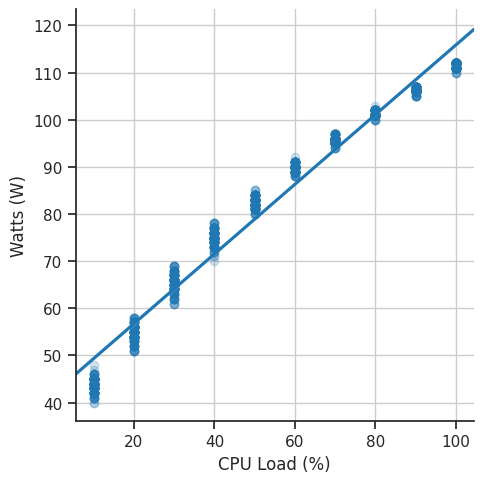

In [40]:
cpu_results = pd.read_csv('base/cpubench/cpubench-log.csv')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(cpu_results['Start'], cpu_results['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

cpu_results = power_metrics.join(cpu_results, on='idx')
cpu_results=cpu_results.reset_index()[['Watts', 'CPU Load']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=cpu_results, x="CPU Load", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
fg.set_axis_labels("CPU Load (%)", "Watts (W)")
plt.show(fg)

## Memory Usage

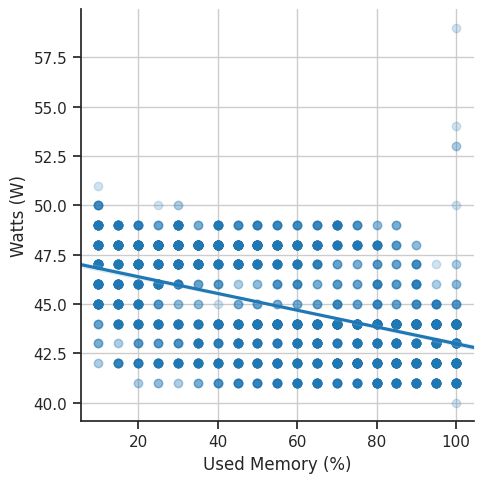

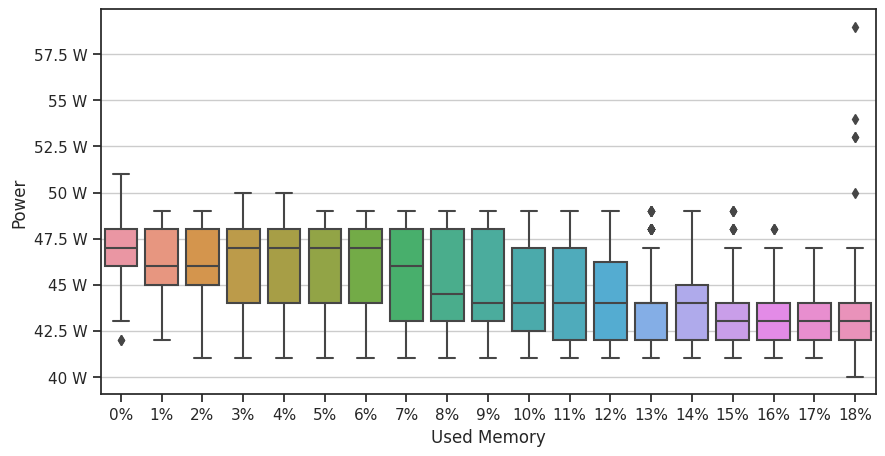

In [41]:
memory_results = pd.read_csv('base/membench/membench-log.csv')
memory_results['Used Memory'] = 100 * memory_results['Used Memory']
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(memory_results['Start'], memory_results['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

memory_results = power_metrics.join(memory_results, on='idx')
memory_results=memory_results.reset_index()[['Watts', 'Used Memory']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=memory_results, x="Used Memory", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
fg.set_axis_labels("Used Memory (%)", "Watts (W)")
plt.show(fg)

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=memory_results, x="Used Memory", y="Watts"
)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.set(xlabel="Used Memory", ylabel="Power")
plt.show(fig)


## Disk I/O

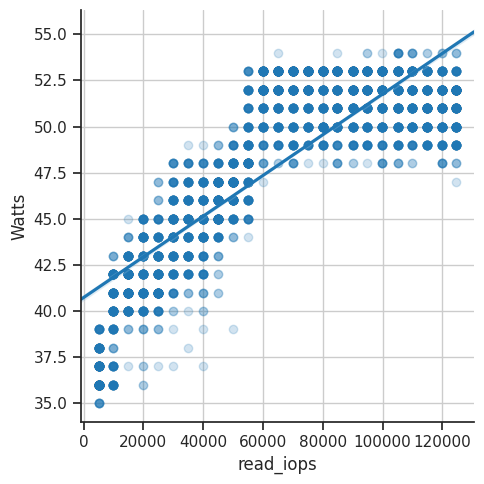

In [42]:
# Disk I/O
IO_RESULTS = pd.read_csv('base/iobench/iobench.csv', sep=';')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(IO_RESULTS['Start'], IO_RESULTS['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

s_io_results = power_metrics.join(IO_RESULTS, on='idx')
s_io_results=s_io_results.reset_index()[['Watts', 'read_iops']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=s_io_results, x="read_iops", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
plt.show(fg)

## Network I/O

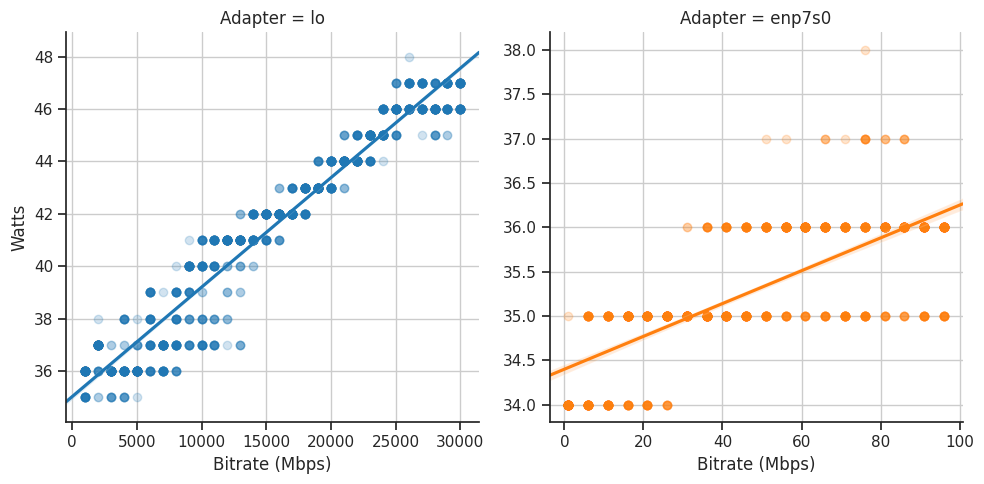

In [43]:
NET_RESULTS = pd.read_csv('base/netbench/netbench-log.csv', sep=',')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(NET_RESULTS['Start'], NET_RESULTS['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

s_net_results = power_metrics.join(NET_RESULTS, on='idx')

s_net_results=s_net_results.reset_index()[['Watts', 'Bitrate', 'Adapter']]
s_net_results['Bitrate'] = s_net_results['Bitrate'].astype(float).div(1000000) # To Mbps

fg = sns.lmplot(
    data=s_net_results, x="Bitrate", y="Watts", hue="Adapter", col="Adapter", scatter=True, truncate=False, scatter_kws={'alpha': .2},
    facet_kws=dict(sharex=False, sharey=False),
)
fg.axes[0,0].set_xlabel('Bitrate (Mbps)')
fg.axes[0,1].set_xlabel('Bitrate (Mbps)')
plt.show(fg)

## Summary

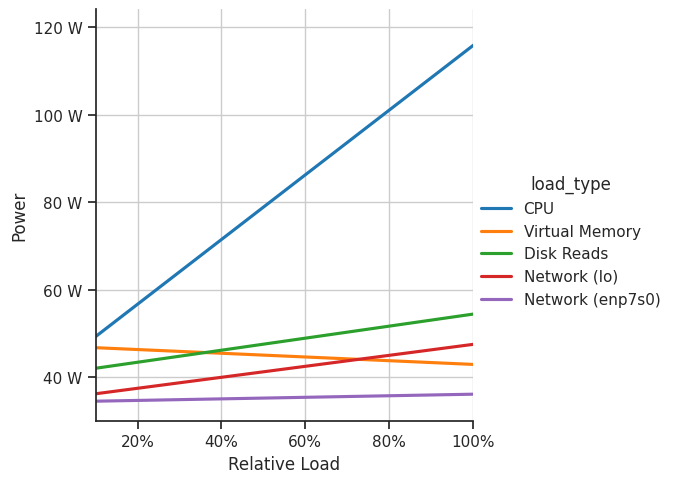

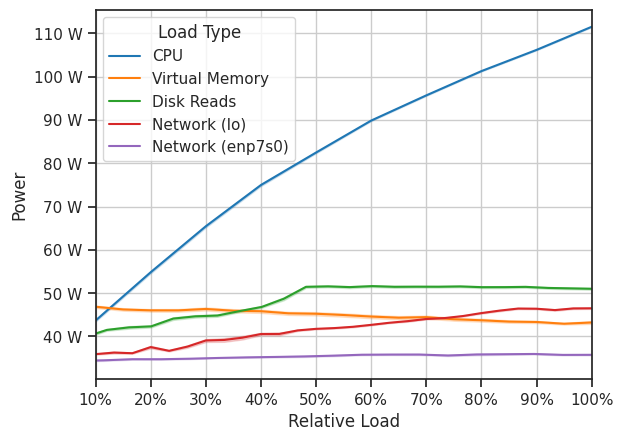

In [44]:
relative_cpu_results=cpu_results
relative_cpu_results['rel_load']=cpu_results['CPU Load'] / cpu_results['CPU Load'].max() * 100
relative_cpu_results=relative_cpu_results.assign(load_type='CPU')

relative_memory_results=memory_results
relative_memory_results['rel_load']=memory_results['Used Memory'] / memory_results['Used Memory'].max() * 100
relative_memory_results=relative_memory_results.assign(load_type='Virtual Memory')

relative_io_results=s_io_results
relative_io_results['rel_load']=s_io_results['read_iops'] / s_io_results['read_iops'].max() * 100
relative_io_results=relative_io_results.assign(load_type='Disk Reads')

relative_net_results=s_net_results
relative_net_results['rel_load']=relative_net_results.groupby('Adapter')['Bitrate'].transform(lambda x: x / x.max() * 100)
relative_net_results=relative_net_results.reset_index()
relative_net_results['load_type'] = relative_net_results.apply(lambda row: f"Network ({row['Adapter']})", axis=1)

# Watts | Relative Load | Type
relative_results = pd.concat([
    relative_cpu_results[['rel_load', 'Watts', 'load_type']],
    relative_memory_results[['rel_load', 'Watts', 'load_type']],
    relative_io_results[['rel_load', 'Watts', 'load_type']], 
    relative_net_results[['rel_load', 'Watts', 'load_type']]
])

fg = sns.lmplot(
    data=relative_results, x="rel_load", y="Watts", hue="load_type", scatter=False, truncate=False
)
fg.axes[0,0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
fg.axes[0,0].yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
fg.axes[0,0].set_xlim(10, 100)
fg.axes[0,0].set_xlabel('Relative Load')
fg.axes[0,0].set_ylabel('Power')
plt.show(fg)

fig, ax = plt.subplots()  
sns.lineplot(
    ax=ax,
    data=relative_results, x="rel_load", y="Watts", hue="load_type"
)
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.set_xlim(10, 100)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Relative Load")
ax.set_ylabel("Power")
ax.legend(title='Load Type')
plt.show(fig)

/tmp/ipykernel_7093/387653195.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in fg._legend.legendHandles:


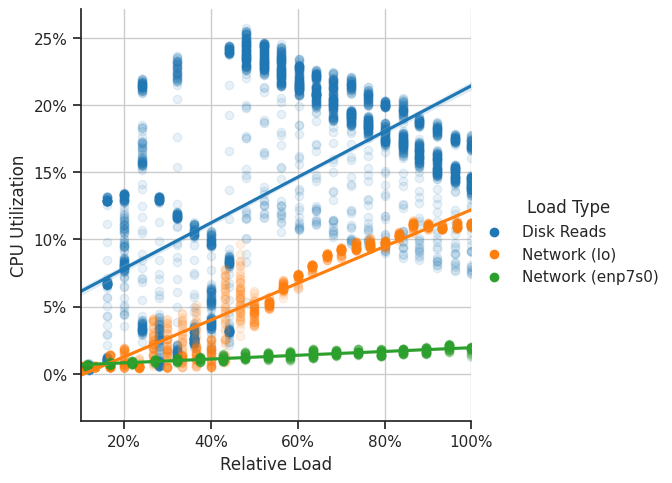

In [45]:
net_cpu_utilization = pd.concat([
    fetch_query_range(Q_CPU_UTILIZATION, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(NET_RESULTS['Start'], NET_RESULTS['End']), 0)
])
net_cpu_utilization = net_cpu_utilization.join(NET_RESULTS, on='idx')
net_cpu_utilization.drop(columns=['{mode="idle"}'], inplace=True)
net_cpu_utilization['utilization'] = net_cpu_utilization.iloc[:, 1:7].sum(axis=1)
net_cpu_utilization['rel_load']=net_cpu_utilization.groupby('Adapter')['Bitrate'].transform(lambda x: x / x.max() * 100)
net_cpu_utilization['load_type'] = net_cpu_utilization.apply(lambda row: f"Network ({row['Adapter']})", axis=1)
net_cpu_utilization=net_cpu_utilization.reset_index()

io_cpu_utilization = pd.concat([
    fetch_query_range(Q_CPU_UTILIZATION, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(IO_RESULTS['Start'], IO_RESULTS['End']), 0)
])
io_cpu_utilization = io_cpu_utilization.join(IO_RESULTS, on='idx')
io_cpu_utilization.drop(columns=['{mode="idle"}'], inplace=True)
io_cpu_utilization['utilization'] = io_cpu_utilization.iloc[:, 1:7].sum(axis=1)
io_cpu_utilization['rel_load']=io_cpu_utilization['read_iops'] / io_cpu_utilization['read_iops'].max() * 100
io_cpu_utilization=io_cpu_utilization.assign(load_type='Disk Reads')
io_cpu_utilization=io_cpu_utilization.reset_index()

relative_results = pd.concat([
    io_cpu_utilization[['rel_load', 'utilization', 'load_type']],
    net_cpu_utilization[['rel_load', 'utilization', 'load_type']]
])

fg = sns.lmplot(
    data=relative_results, x="rel_load", y="utilization", hue="load_type", 
    scatter=True, truncate=False, scatter_kws={'alpha': .1}
)
ax = fg.axes[0,0]
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlim(10, 100)
ax.set_xlabel("Relative Load")
ax.set_ylabel("CPU Utilization")
fg._legend.set_title('Load Type')

for lh in fg._legend.legendHandles:
    lh.set_alpha(1)

plt.show(fg)

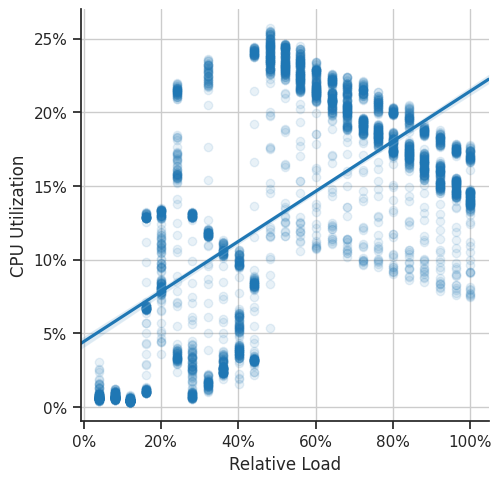

In [46]:
io_cpu_utilization = pd.concat([
    fetch_query_range(Q_CPU_UTILIZATION, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(IO_RESULTS['Start'], IO_RESULTS['End']), 0)
])
io_cpu_utilization = io_cpu_utilization.join(IO_RESULTS, on='idx')
io_cpu_utilization.drop(columns=['{mode="idle"}'], inplace=True)
io_cpu_utilization['utilization'] = io_cpu_utilization.iloc[:, 1:7].sum(axis=1)
io_cpu_utilization['rel_load']=io_cpu_utilization['read_iops'] / io_cpu_utilization['read_iops'].max() * 100
io_cpu_utilization=io_cpu_utilization.reset_index()
#display(io_cpu_utilization)


fg = sns.lmplot(
    data=io_cpu_utilization, x="rel_load", y="utilization", 
    scatter=True, truncate=False, scatter_kws={'alpha': .1}
)
ax = fg.axes[0,0]
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Relative Load")
ax.set_ylabel("CPU Utilization")

plt.show(fg)

# Baseline Analysis

Here we take a look at the Baseline of our DUT


In [47]:
bm = pd.read_csv('base/baseline.csv')
bm

,Start,End,Duration,Energy
0,1682782920,1682783220,5m,2


## Power Stats

count    301.000000
mean      33.006645
std        0.081378
min       33.000000
25%       33.000000
50%       33.000000
75%       33.000000
max       34.000000
Name: Watts, dtype: float64

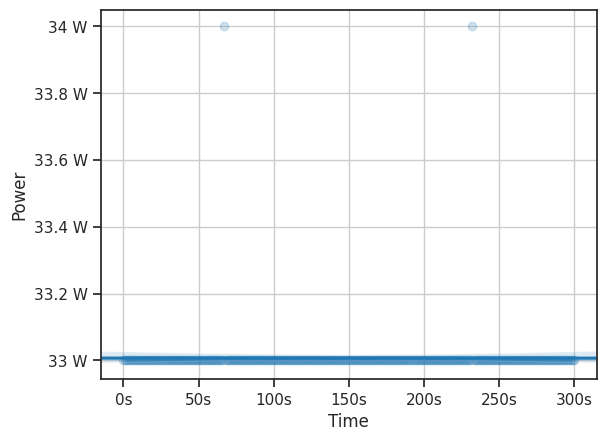

In [48]:
power_metrics = pd.concat([
    prepare_query_range_as_dataframe(Q_POWER, start, end).assign(idx=idx) for idx, (start, end) in enumerate(zip(bm['Start'], bm['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

display(power_metrics['Watts'].describe())

fg = sns.regplot(
    data=power_metrics, x="seconds", y="Watts", scatter=True, truncate=False,
    scatter_kws={'alpha': .2}
)
fg.axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}s'))
fg.axes.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
fg.axes.set_xlabel('Time')
fg.axes.set_ylabel('Power')
plt.show(fg)

# Case Study 1: Caching

In [49]:
# Those are the variants we have measured
VARIANTS=["no-cache", "caffeine-cache", "redis-cache"]
data_measurement = pd.read_csv("case-study-caching/benchmark-log.csv")

## Power Consumption

### Raw Data Samples

,index,Power,Watts,Voltage,delta,seconds,idx,variant
0,2023-04-29 19:19:42,211.0,33.0,236.0,0 days 00:00:00,0,1,no-cache
1,2023-04-29 19:19:43,210.0,33.0,237.0,0 days 00:00:01,1,1,no-cache
2,2023-04-29 19:19:44,211.0,33.0,236.0,0 days 00:00:02,2,1,no-cache
3,2023-04-29 19:19:45,210.0,33.0,236.0,0 days 00:00:03,3,1,no-cache
4,2023-04-29 19:19:46,225.0,37.0,237.0,0 days 00:00:04,4,1,no-cache
...,...,...,...,...,...,...,...,...
10672,2023-04-30 00:43:12,418.0,87.0,237.0,0 days 00:01:49,109,31,redis-cache
10673,2023-04-30 00:43:13,420.0,88.0,238.0,0 days 00:01:50,110,31,redis-cache
10674,2023-04-30 00:43:14,417.0,87.0,238.0,0 days 00:01:51,111,31,redis-cache
10675,2023-04-30 00:43:15,414.0,86.0,238.0,0 days 00:01:52,112,31,redis-cache


### Wattage

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
caffeine-cache,3569.0,70.388064,8.503915,33.0,71.0,72.0,73.0,88.0
no-cache,3553.0,79.547425,9.862972,33.0,81.0,82.0,83.0,86.0
redis-cache,3555.0,81.270323,10.488534,33.0,83.0,83.0,85.0,89.0


### See the distribution of the measurements

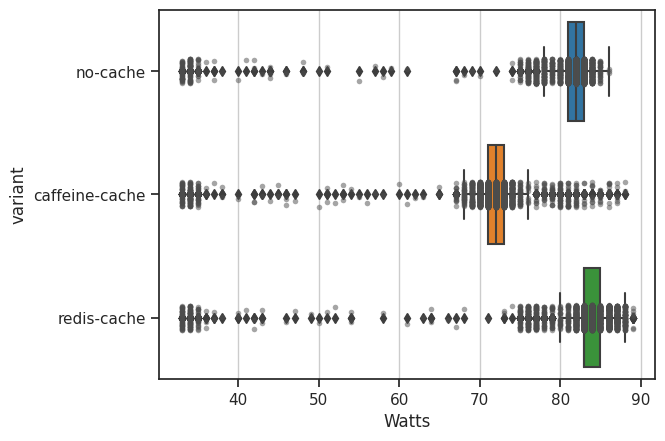

### See how the variants behave over time

<Figure size 1000x300 with 0 Axes>

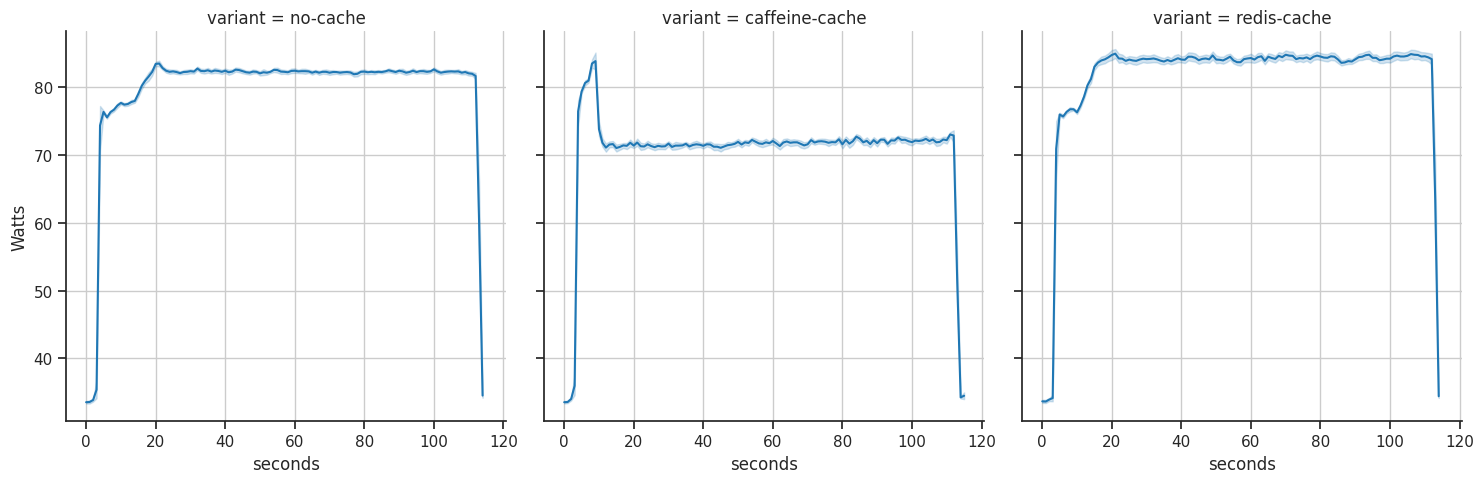

### Linear regression

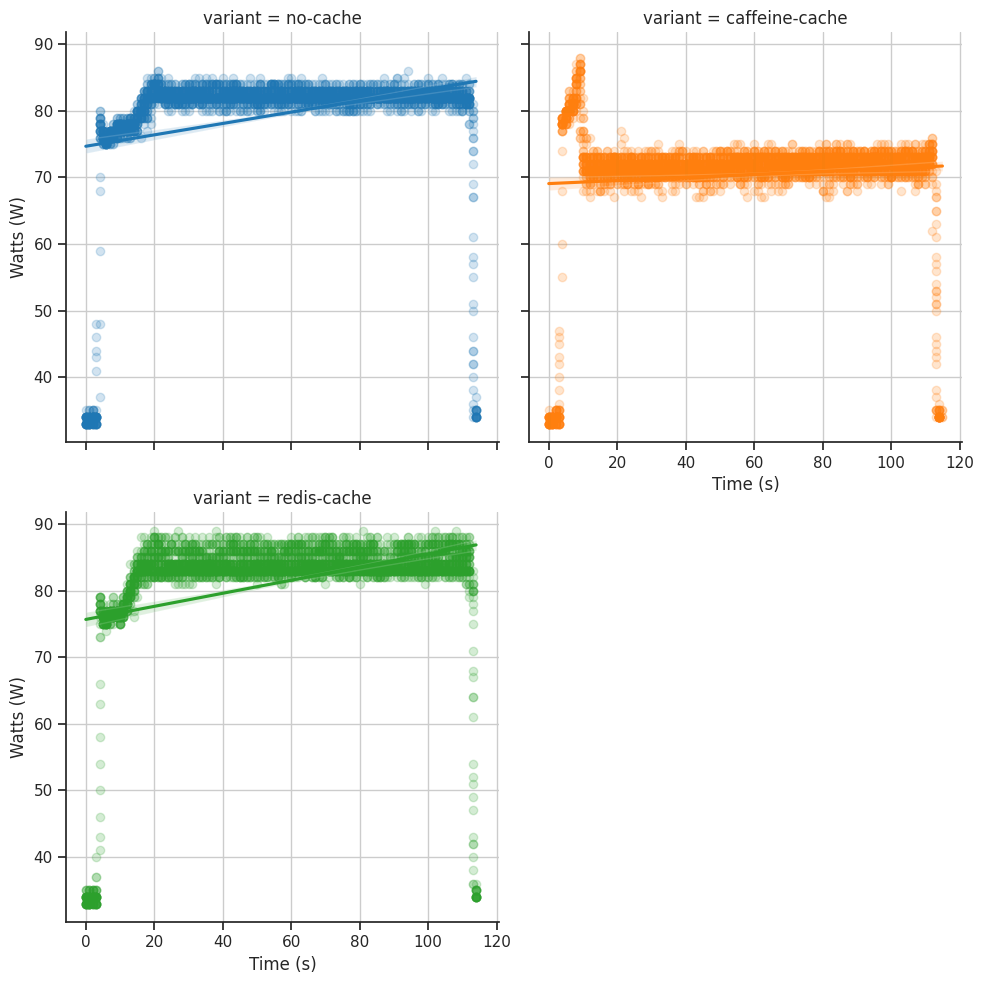

In [50]:
POWER_METRICS = pd.concat([prepare_dataframe(Q_POWER, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in VARIANTS])
POWER_METRICS.columns.values[0] = "Power"
POWER_METRICS.columns.values[1] = "Watts"
POWER_METRICS.columns.values[2] = "Voltage"

display(Markdown("## Power Consumption"))
POWER_METRICS.reset_index(inplace=True)

display(Markdown("### Raw Data Samples"))
display(POWER_METRICS)

display(Markdown("### Wattage"))
display(POWER_METRICS.groupby(by=['variant'])['Watts'].describe())

# Boxplot
display(Markdown("### See the distribution of the measurements"))
f, ax = plt.subplots()
sns.boxplot(x="Watts", y="variant", data=POWER_METRICS)
sns.stripplot(x="Watts", y="variant", data=POWER_METRICS, size=4, color=".3", linewidth=0, alpha=.5)
plt.show(f)

# Lineplot of measurment distribution
display(Markdown("### See how the variants behave over time"))
f = plt.figure(figsize=(10,3))
sns.relplot(
    data=POWER_METRICS, x="seconds", y="Watts", col="variant", kind="line"
)
plt.show(f)



# Linear regression
display(Markdown("### Linear regression"))
fg = sns.lmplot(
    data=POWER_METRICS, x="seconds", y="Watts", hue="variant", col="variant", col_wrap=2,
    scatter_kws={'alpha': .2}
    
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("Watts (W)")
plt.show(fg)

count     mean  std      min      25%      50%   
variant        mode                                                      
caffeine-cache idle       1.0  1034.81  NaN  1034.81  1034.81  1034.81  \
               iowait     1.0     0.40  NaN     0.40     0.40     0.40   
               irq        1.0     0.00  NaN     0.00     0.00     0.00   
               nice       1.0     0.00  NaN     0.00     0.00     0.00   
               softirq    1.0   171.69  NaN   171.69   171.69   171.69   
               steal      1.0     0.00  NaN     0.00     0.00     0.00   
               system     1.0   267.92  NaN   267.92   267.92   267.92   
               user       1.0   256.34  NaN   256.34   256.34   256.34   
no-cache       idle       1.0   691.97  NaN   691.97   691.97   691.97   
               iowait     1.0     0.23  NaN     0.23     0.23     0.23   
               irq        1.0     0.00  NaN     0.00     0.00     0.00   
               nice       1.0     0.00  NaN     0.00     0.00     0.00   
               softirq    1.0   183.23  NaN   183.23   183.23   183.23   
               steal      1.0     0.00  NaN     0.00     0.00     0.00   
               system     1.0   308.86  NaN   308.86   308.86   308.86   
               user       1.0   553.56  NaN   553.56   553.56   553.56   
redis-cache    idle       1.0   438.59  NaN   438.59   438.59   438.59   
               iowait     1.0     0.04  NaN     0.04     0.04     0.04   
               irq        1.0     0.00  NaN     0.00     0.00     0.00   
               nice       1.0     0.00  NaN     0.00     0.00     0.00   
               softirq    1.0   195.79  NaN   195.79   195.79   195.79   
               steal      1.0     0.00  NaN     0.00     0.00     0.00   
               system     1.0   349.66  NaN   349.66   349.66   349.66   
               user       1.0   500.74  NaN   500.74   500.74   500.74   

                            75%      max  
variant        mode                       
caffeine-cache idle     1034.81  1034.81  
               iowait      0.40     0.40  
               irq         0.00     0.00  
               nice        0.00     0.00  
               softirq   171.69   171.69  
               steal       0.00     0.00  
               system    267.92   267.92  
               user      256.34   256.34  
no-cache       idle      691.97   691.97  
               iowait      0.23     0.23  
               irq         0.00     0.00  
               nice        0.00     0.00  
               softirq   183.23   183.23  
               steal       0.00     0.00  
               system    308.86   308.86  
               user      553.56   553.56  
redis-cache    idle      438.59   438.59  
               iowait      0.04     0.04  
               irq         0.00     0.00  
               nice        0.00     0.00  
               softirq   195.79   195.79  
               steal       0.00     0.00  
               system    349.66   349.66  
               user      500.74   500.74

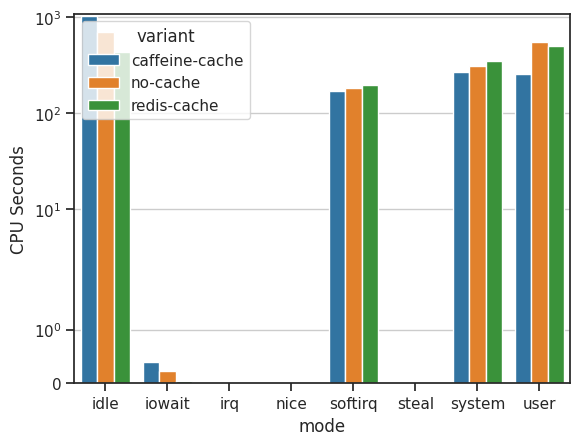

In [51]:
CPU_SECONDS = pd.concat(
    [prepare_dataframe("sum by (mode) (node_cpu_seconds_total)", data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in VARIANTS]
    )
CPU_SECONDS.columns.values[0] = "idle"
CPU_SECONDS.columns.values[1] = "iowait"
CPU_SECONDS.columns.values[2] = "irq"
CPU_SECONDS.columns.values[3] = "nice"
CPU_SECONDS.columns.values[4] = "softirq"
CPU_SECONDS.columns.values[5] = "steal"
CPU_SECONDS.columns.values[6] = "system"
CPU_SECONDS.columns.values[7] = "user"
# I have tried to do that with grouping but idk how to do it
GROUPED=CPU_SECONDS.groupby(by=['variant'])
CPU_SECONDS['idle'] = (CPU_SECONDS['idle'] - GROUPED['idle'].shift()).fillna(0)
CPU_SECONDS['iowait'] = (CPU_SECONDS['iowait'] - GROUPED['iowait'].shift()).fillna(0)
CPU_SECONDS['irq'] = (CPU_SECONDS['irq'] - GROUPED['irq'].shift()).fillna(0)
CPU_SECONDS['nice'] = (CPU_SECONDS['nice'] - GROUPED['nice'].shift()).fillna(0)
CPU_SECONDS['softirq'] = (CPU_SECONDS['softirq'] - GROUPED['softirq'].shift()).fillna(0)
CPU_SECONDS['steal'] = (CPU_SECONDS['steal'] - GROUPED['steal'].shift()).fillna(0)
CPU_SECONDS['system'] = (CPU_SECONDS['system'] - GROUPED['system'].shift()).fillna(0)
CPU_SECONDS['user'] = (CPU_SECONDS['user'] - GROUPED['user'].shift()).fillna(0)
CPU_SECONDS=CPU_SECONDS.melt(
    value_vars=['idle', 'iowait', 'irq', 'nice', 'softirq', 'steal', 'system', 'user'], 
    id_vars=['seconds', 'variant'], 
    var_name='mode', 
    value_name='CPU Seconds')
CPU_SECONDS=CPU_SECONDS.groupby(
    by=['variant', 'mode']).sum()
CPU_SECONDS.reset_index(inplace=True)
display(CPU_SECONDS.groupby(by=['variant', 'mode'])['CPU Seconds'].describe())

g = sns.barplot(
    data=CPU_SECONDS, x="mode", y="CPU Seconds", hue="variant", errorbar="sd"
)
g.set_yscale("symlog")

,seconds,variant,utilization
2023-04-29 19:19:47,0,no-cache,21.005746
2023-04-29 19:19:48,1,no-cache,30.777958
2023-04-29 19:19:49,2,no-cache,40.732996
2023-04-29 19:19:50,3,no-cache,50.760510
2023-04-29 19:19:51,4,no-cache,60.844514
...,...,...,...
2023-04-30 00:43:07,99,redis-cache,56.513889
2023-04-30 00:43:08,100,redis-cache,56.236111
2023-04-30 00:43:09,101,redis-cache,55.944444
2023-04-30 00:43:10,102,redis-cache,56.486111


<Figure size 1000x300 with 0 Axes>

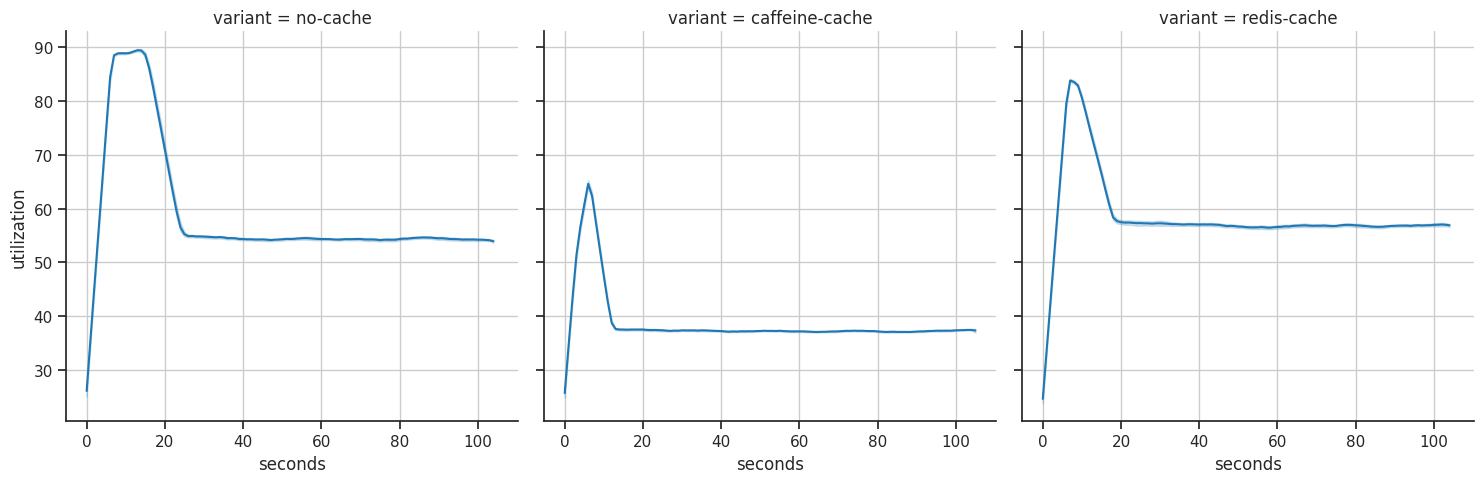

In [52]:
CPU_UTILIZATION = pd.concat(
    [prepare_dataframe(Q_CPU_UTILIZATION, data_measurement.loc[data_measurement['Variant'] == v], offset_start=5, offset_end=5).assign(variant=v) for v in VARIANTS]
    )
# We don't care
#CPU_UTILIZATION.drop(columns=['{mode="idle"}', 'delta'], inplace=True)
CPU_UTILIZATION['utilization'] = CPU_UTILIZATION.loc[:, ['{mode="iowait"}', '{mode="irq"}', '{mode="nice"}', '{mode="softirq"}', '{mode="steal"}', '{mode="system"}','{mode="user"}']].sum(axis=1)
CPU_UTILIZATION = CPU_UTILIZATION.loc[:, ['seconds', 'variant', 'utilization']]

display(CPU_UTILIZATION)
f = plt.figure(figsize=(10,3))
sns.relplot(
    data=CPU_UTILIZATION, x="seconds", y="utilization", col="variant", kind="line"
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("CPU Utilization (%)")
plt.show(f)

# Case Study 2: Dungeon

In [53]:
VARIANTS=["microservice", "monolith"]
data_measurement = pd.read_csv("case-study-dungeon/benchmark-log.csv")

## Power Consumption

### Wattage

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
microservice,4213.0,39.416568,8.439015,34.0,35.0,36.0,39.0,91.0
monolith,4207.0,38.642738,5.753909,34.0,35.0,37.0,39.0,74.0


### See the distribution of the measurements

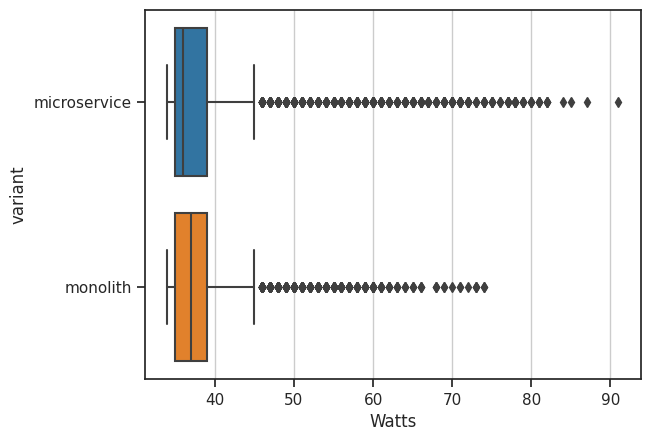

In [54]:
POWER_METRICS = pd.concat([prepare_dataframe(Q_POWER, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in VARIANTS])
POWER_METRICS.columns.values[0] = "Power"
POWER_METRICS.columns.values[1] = "Watts"
POWER_METRICS.columns.values[2] = "Voltage"

display(Markdown("## Power Consumption"))
POWER_METRICS.reset_index(inplace=True)

# display(Markdown("### Raw Data Samples"))
# display(POWER_METRICS)

display(Markdown("### Wattage"))
display(POWER_METRICS.groupby(by=['variant'])['Watts'].describe())

# Boxplot
display(Markdown("### See the distribution of the measurements"))
f, ax = plt.subplots()
sns.boxplot(x="Watts", y="variant", data=POWER_METRICS)
# sns.stripplot(x="Watts", y="variant", data=POWER_METRICS, size=4, color=".3", linewidth=0, alpha=.5)
plt.show(f)



### See the distribution of Peaks

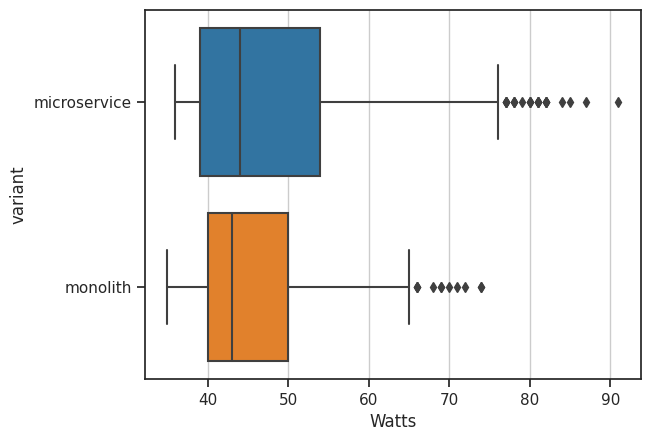

In [55]:
def get_power_peaks(df, order=1):
    df.columns.values[1] = "Watts"
    return df.iloc[argrelmax(df['Watts'].values, order=order)[0]]

POWER_METRICS_PEAKS = pd.concat([get_power_peaks(prepare_dataframe(Q_POWER, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v)) for v in VARIANTS])
POWER_METRICS_PEAKS = POWER_METRICS_PEAKS.loc[:, ['seconds', 'variant', 'Watts']]

# Boxplot
display(Markdown("### See the distribution of Peaks"))
f, ax = plt.subplots()
sns.boxplot(x="Watts", y="variant", data=POWER_METRICS_PEAKS)
# sns.stripplot(x="Watts", y="variant", data=POWER_METRICS, size=4, color=".3", linewidth=0, alpha=.5)
plt.show(f)

,seconds,variant,utilization
2023-04-29 14:56:27,0,microservice,10.493056
2023-04-29 14:56:28,1,microservice,12.402778
2023-04-29 14:56:29,2,microservice,22.041667
2023-04-29 14:56:30,3,microservice,31.555556
2023-04-29 14:56:31,4,microservice,40.138889
...,...,...,...
2023-04-30 02:52:36,586,monolith,7.784722
2023-04-30 02:52:37,587,monolith,9.361111
2023-04-30 02:52:38,588,monolith,10.451389
2023-04-30 02:52:39,589,monolith,10.569444


<Figure size 1000x300 with 0 Axes>

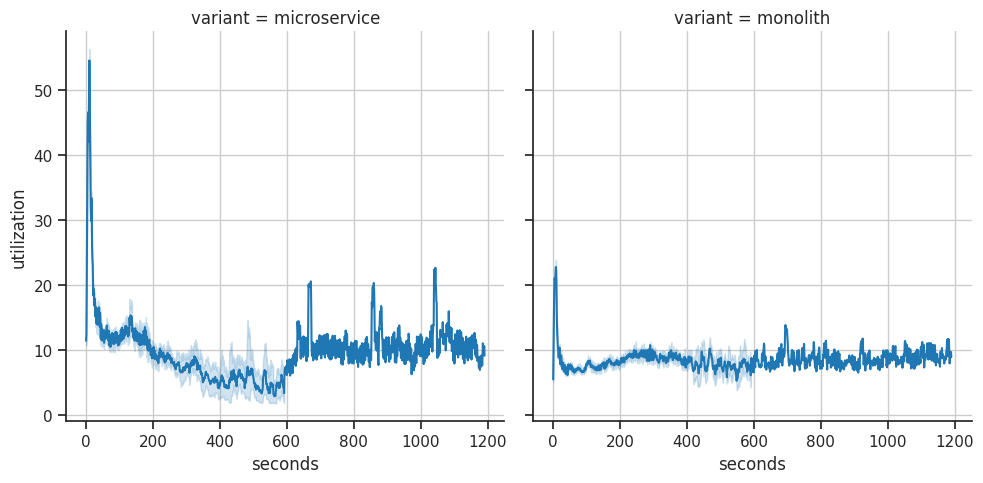

In [56]:
CPU_UTILIZATION = pd.concat(
    [prepare_dataframe(Q_CPU_UTILIZATION, data_measurement.loc[data_measurement['Variant'] == v], offset_start=5, offset_end=5).assign(variant=v) for v in VARIANTS]
    )
# We don't care
#CPU_UTILIZATION.drop(columns=['{mode="idle"}', 'delta'], inplace=True)
CPU_UTILIZATION['utilization'] = CPU_UTILIZATION.loc[:, ['{mode="iowait"}', '{mode="irq"}', '{mode="nice"}', '{mode="softirq"}', '{mode="steal"}', '{mode="system"}','{mode="user"}']].sum(axis=1)
CPU_UTILIZATION = CPU_UTILIZATION.loc[:, ['seconds', 'variant', 'utilization']]

display(CPU_UTILIZATION)
f = plt.figure(figsize=(10,3))
sns.relplot(
    data=CPU_UTILIZATION, x="seconds", y="utilization", col="variant", kind="line"
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("CPU Utilization (%)")
plt.show(f)

<Figure size 1000x300 with 0 Axes>

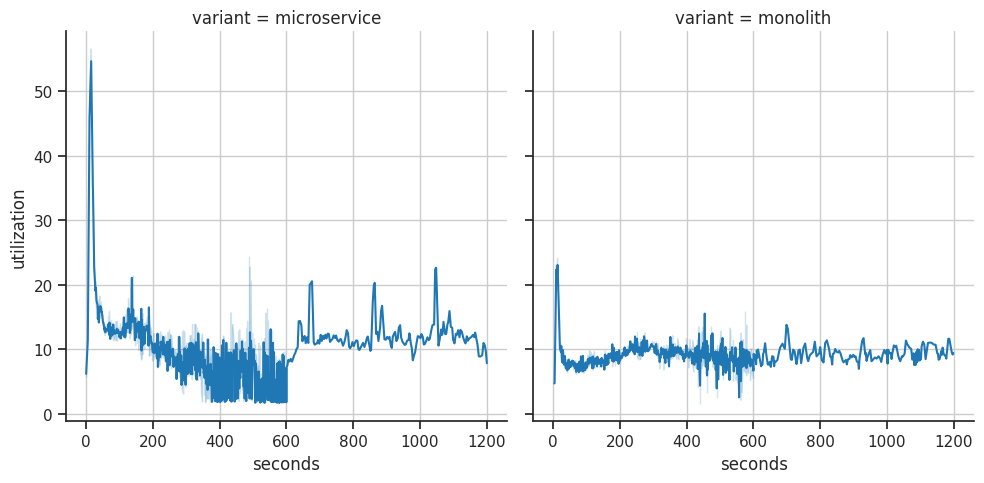

In [57]:
def get_cpu_peaks(df, order=1):
    df['utilization'] = df.loc[:, ['{mode="iowait"}', '{mode="irq"}', '{mode="nice"}', '{mode="softirq"}', '{mode="steal"}', '{mode="system"}','{mode="user"}']].sum(axis=1)
    return df.iloc[argrelmax(df['utilization'].values, order=order)[0]]

CPU_UTILIZATION_PEAKS = pd.concat([
        get_cpu_peaks(prepare_dataframe(Q_CPU_UTILIZATION, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v)) for v in VARIANTS
    ])
CPU_UTILIZATION_PEAKS = CPU_UTILIZATION_PEAKS.loc[:, ['seconds', 'variant', 'utilization']]
f = plt.figure(figsize=(10,3))
sns.relplot(
    data=CPU_UTILIZATION_PEAKS, x="seconds", y="utilization", col="variant", kind="line"
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("CPU Utilization (%)")
plt.show(f)